In [1]:
%cd ..

D:\study\codesum\code-transformer


## explore quality ~ method length

In [2]:
from ast import literal_eval
import os
import pandas as pd
import csv
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

In [3]:
def get_micro_scores(data):
    tps = data.tp.tolist()
    fps = data.fp.tolist()
    fns = data.fn.tolist()
    
    recalls = []
    precisions = []
    f1s = []
    for tp, fp, fn in zip(tps, fps, fns):
        if tp+fn > 0:
            recall = tp / (tp+fn)
        else:
            recall = 0
        recalls.append(recall)
        if tp+fp > 0:
            precision = tp / (tp+fp)
        else:
            precision = 0    
        precisions.append(precision)
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        f1s.append(f1)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    
    return precisions.mean(), recalls.mean(), f1s.mean(),

def mean_precision(data):
    return get_micro_scores(data)[0]

def mean_recall(data):
    return get_micro_scores(data)[1]

def mean_f1(data):
    return get_micro_scores(data)[2]


def get_macro_scores(data):
    tps = data.tp.tolist()
    fps = data.fp.tolist()
    fns = data.fn.tolist()
    
    tp = sum(tps)
    fp = sum(fps)
    fn = sum(fns)
    precision = tp / (tp+fp) if (tp+fp) > 0 else 0
    recall = tp / (tp+fn) if (tp+fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

def macro_precision(data):
    return get_macro_scores(data)[0]

def macro_recall(data):
    return get_macro_scores(data)[1]

def macro_f1(data):
    return get_macro_scores(data)[2]


def rouge_l_f(data):
    return data['rougeL-f'].mean()


def chrf(data):
    return data['chrf'].apply(lambda s: float(s.split(' ')[-1])).mean() / 100

In [4]:
results_dir = "experiments_results"
csn_langs = ['python', 'javascript', 'ruby', 'go']

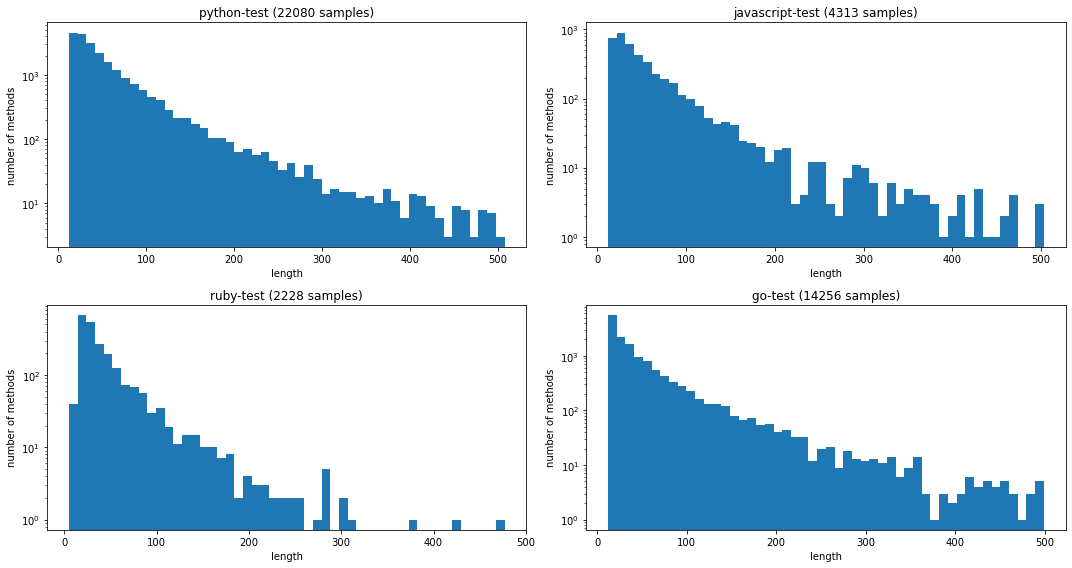

In [5]:
partition = 'test'

plt.figure(figsize=(15,8))
for i in range(1, 5):
    lang = lang = csn_langs[(i - 1) % 4]
    save_path = os.path.join(results_dir, f"sample-metrics-code_transformer-{lang}-{partition}.csv")
    if not os.path.exists(save_path):
        print(f'coudnt find file {save_path}')
        continue

    metrics = pd.read_csv(save_path)
    n = len(metrics)
    
    plt.subplot(2, 2, i)
    plt.title(f'{lang}-{partition} ({n} samples)')
    plt.xlabel('length')
    plt.ylabel('number of methods')
    plt.hist(metrics.length, bins=50,  log=True)
#     metrics.length.plot.hist(bins=20, title=f'{lang}-{partition}', log=True, ax=col)
plt.tight_layout()
plt.show()

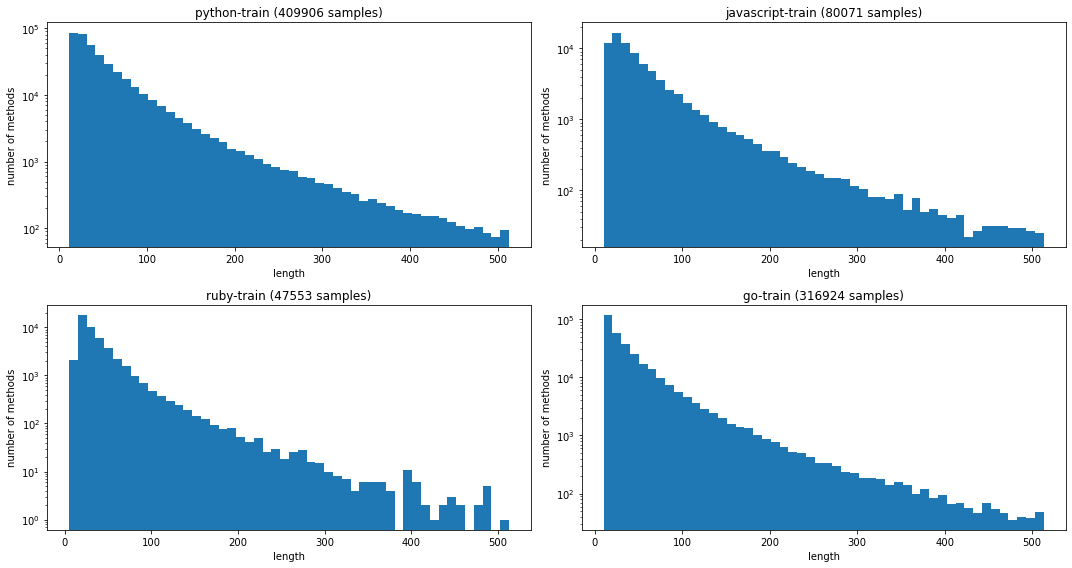

In [6]:
partition = 'train'

plt.figure(figsize=(15,8))
for i in range(1, 5):
    lang = lang = csn_langs[(i - 1) % 4]
    
    save_path = os.path.join("samples_info", f'lengths-{lang}-{partition}.npy')
    if not os.path.exists(save_path):
        print(f'coudnt find file {save_path}')
        continue

    lengths = np.load(save_path)
    n = len(lengths)

    plt.subplot(2, 2, i)
    plt.title(f'{lang}-{partition} ({n} samples)')
    plt.xlabel('length')
    plt.ylabel('number of methods')
    plt.hist(lengths, bins=50,  log=True)
plt.tight_layout()
plt.show()

In [7]:
def experiments_configs_generator(experiments_dir, partition='test'):
    snapshot = 'latest'
    partition = 'test'
    models = [dict(model='code_transformer',    label='CT', run_ids=range(5, 9)), 
              dict(model='great',               label='GT', run_ids=range(1, 5)),
              dict(model='xl_net',              label='XL', run_ids=range(1, 5))]
    csn_langs = ['python', 'javascript', 'ruby', 'go']
    
    for i, model_info in enumerate(models):
        model = model_info['model']
        for run_id in model_info['run_ids']:
            lang = csn_langs[(run_id - 1) % 4]
            save_path = os.path.join(experiments_dir, f"sample-metrics-{model}-{lang}-{partition}.csv")
            yield model, lang, partition, save_path

In [8]:
def length_balanced_experiments_generator(experiments_dir):
    partition = 'test'
    model='code_transformer'
    label='CT'
    models = [dict(desc='balanced_normilized_weights', snapshots=[50000])]

    results_dir = 'experiments_results_len_balanced'

    lang = 'python'
    os.makedirs(experiments_dir, exist_ok=True)
    for model_info in models:
        desc = model_info['desc']
        for snapshot in model_info['snapshots']:
            save_path = os.path.join(experiments_dir, 
                                     f"sample-metrics-{model}-{lang}-{partition}-{desc}-{snapshot}.csv")
            yield f'{model}-{desc}-{snapshot}', lang, partition, save_path

In [9]:
import numpy as np
import scipy

ROUND_PREC = 3

def bootstrap_metric_confidence(data, metric_fn, sample_size=100, n_resample=1000, alpha=0.95):
    metrics = [metric_fn(data.sample(n=sample_size, replace=True, random_state=i))
               for i in range(n_resample)]
    n = len(metrics)
    m, se = np.mean(metrics), scipy.stats.sem(metrics)
    h = se * scipy.stats.t.ppf((1 + alpha) / 2., n-1)
    return round(m, ROUND_PREC), round(m-h, ROUND_PREC), round(m+h, ROUND_PREC)

In [10]:
def plot_results(res):
    for model in res:
        print(model)
        plt.figure(figsize=(15, 10))
        for i, lang in enumerate(res[model]):
            plt.subplot(2, 2, i+1)
            plt.title(lang)
            plt.xlabel('avg method length in bin')
            for xs, ys, errors, metric_name in res[model][lang]:
                plt.errorbar(xs, ys, yerr=errors, label=metric_name)
            plt.legend()
        plt.show()

In [11]:
MAX_TOKENS = 512

metric_fns = [mean_f1,
              macro_f1,
              rouge_l_f,
              chrf]

fields = ['model','data', 'bins'] + [metric_fn.__name__ + suff 
                                     for metric_fn in metric_fns
                                     for suff in ['', '-conf', '-corr', '-ndcg'] 
                                     ]

MIN_BIN_SIZE = 100
BIN_WIDTH = 25

def process_results_balanced(experiments_dir, summary_file, exp_generator, log=False):
    with open(summary_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(fields)
    
    res = {}  
    for model, lang, partition, save_path in exp_generator(experiments_dir):
        if not os.path.exists(save_path):
            print(f'coudnt find file {save_path}')
            continue
        print(f'calculating metrics for {model}-{lang} on {partition}...')

        metrics = pd.read_csv(save_path)
        metrics.drop(metrics[metrics.length > MAX_TOKENS].index, inplace=True)
        metrics.sort_values('length', inplace=True)
                
        metrics['bin'] = metrics.length // BIN_WIDTH
        groups = metrics.groupby('bin')
        length_bins = [groups.get_group(g) for g in groups.groups]
        
        # drop too small bins
        length_bins = [length_bin for length_bin in length_bins if len(length_bin) >= MIN_BIN_SIZE]
        bins_num = len(length_bins)
        bins_sizes = [len(length_bin) for length_bin in length_bins]
        mean_length_in_bin = [round(length_bin.length.mean(), ROUND_PREC) for length_bin in length_bins]
        
        intervals = [(i*BIN_WIDTH, (i+1) * BIN_WIDTH) for i in range(bins_num)]
        intervals_str = ', '.join([f'[{l}, {r})' for l, r in intervals])
        intervals_str = intervals_str[:-1] + ']'
        
        summary_row = [model, lang, intervals_str]
        
        if log:
            print('splitted into bins:', intervals_str)
            print("bins num:", bins_num)
            print(f'bins sizes:', bins_sizes)
            print('mean length in bins:', mean_length_in_bin)
        
        for metric_fn in metric_fns:
            mean, left, right = map(list, zip(*[bootstrap_metric_confidence(length_bin, 
                                                                  metric_fn, 
                                                                  sample_size=min(bins_sizes))
                                      for length_bin in length_bins]))
            
            conf = list(zip(left, right))
            corr = round(scipy.stats.pearsonr(mean_length_in_bin, mean)[0], 2)
            ndcg = round(ndcg_score([[1/l for l in mean_length_in_bin]], [mean]), 2)

            summary_row.extend([mean, conf, corr, ndcg])
            
            res.setdefault(model, defaultdict(list))
            res[model][lang].append((mean_length_in_bin, mean, [m-l for m, l in zip(mean, left)], metric_fn.__name__))
            
            if log: 
                means_str = [f'{x}±{round(x-y, ROUND_PREC)}' for x, y, _ in zip(mean, left, right)]
                print(f'{metric_fn.__name__}: {means_str} \n corr:{corr}\n ndcg:{ndcg}\n')
        
        with open(summary_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(summary_row)
        if log: print('-----------------------------------------------------------------')
        
    return res

In [12]:
experiments_dir = 'experiments_results'
summary_file = os.path.join(experiments_dir, 'summary.csv')

res = process_results_balanced(experiments_dir, summary_file, experiments_configs_generator, log=False)

calculating metrics for code_transformer-python on test...
calculating metrics for code_transformer-javascript on test...
calculating metrics for code_transformer-ruby on test...
calculating metrics for code_transformer-go on test...
calculating metrics for great-python on test...
calculating metrics for great-javascript on test...
calculating metrics for great-ruby on test...
calculating metrics for great-go on test...
calculating metrics for xl_net-python on test...
calculating metrics for xl_net-javascript on test...
calculating metrics for xl_net-ruby on test...
calculating metrics for xl_net-go on test...


code_transformer


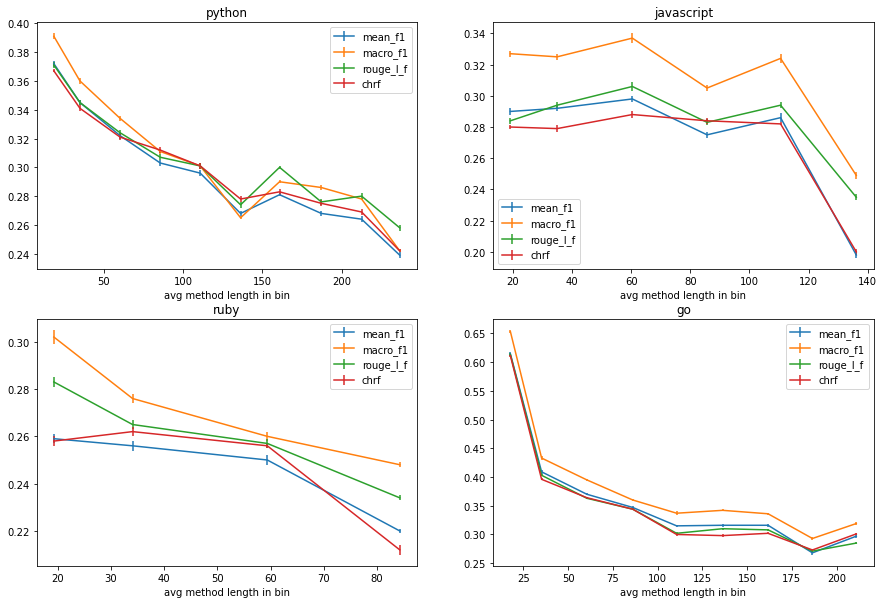

great


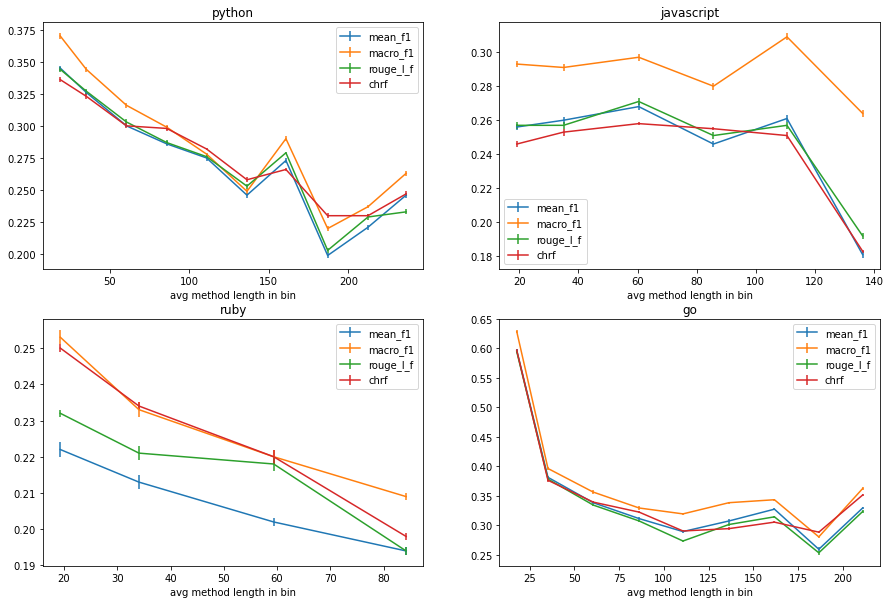

xl_net


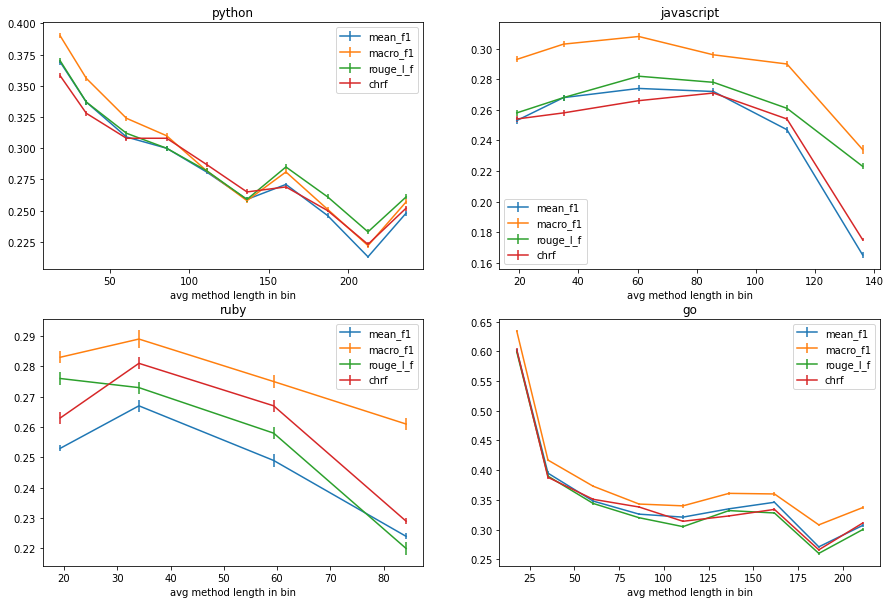

In [13]:
plot_results(res)

In [14]:
summary = pd.read_csv(summary_file)

In [15]:
summary[['model', 'data', 
         'mean_f1-corr',   'mean_f1-ndcg',
         'macro_f1-corr',  'macro_f1-ndcg',  
         'rouge_l_f-corr', 'rouge_l_f-ndcg', 
         'chrf-corr',      'chrf-ndcg']]

,model,data,mean_f1-corr,mean_f1-ndcg,macro_f1-corr,macro_f1-ndcg,rouge_l_f-corr,rouge_l_f-ndcg,chrf-corr,chrf-ndcg
0,code_transformer,python,-0.95,1.00,-0.91,1.00,-0.92,1.00,-0.96,1.00
1,code_transformer,javascript,-0.73,0.80,-0.72,0.83,-0.61,0.75,-0.64,0.72
2,code_transformer,ruby,-0.92,1.00,-0.96,1.00,-0.98,1.00,-0.84,0.90
3,code_transformer,go,-0.79,1.00,-0.78,1.00,-0.79,1.00,-0.76,1.00
4,great,python,-0.89,1.00,-0.87,1.00,-0.92,1.00,-0.95,1.00
5,great,javascript,-0.67,0.74,-0.39,0.73,-0.68,0.79,-0.63,0.72
6,great,ruby,-0.99,1.00,-0.97,1.00,-0.95,1.00,-0.99,1.00
7,great,go,-0.65,0.99,-0.62,0.98,-0.66,0.99,-0.61,0.99
8,xl_net,python,-0.93,1.00,-0.92,1.00,-0.90,1.00,-0.95,1.00
9,xl_net,javascript,-0.68,0.75,-0.72,0.77,-0.54,0.72,-0.63,0.71


In [16]:
experiments_dir = 'experiments_results_len_balanced'
summary_file_balanced = os.path.join(experiments_dir, 'summary_length_balanced.csv')

res_balanced = process_results_balanced(experiments_dir, summary_file_balanced, length_balanced_experiments_generator, log=False)

calculating metrics for code_transformer-balanced_normilized_weights-50000-python on test...


In [17]:
summary_balanced = pd.read_csv(summary_file_balanced)

In [18]:
summary_balanced[['model', 'data', 
         'mean_f1-corr',   'mean_f1-ndcg',
         'macro_f1-corr',  'macro_f1-ndcg',  
         'rouge_l_f-corr', 'rouge_l_f-ndcg', 
         'chrf-corr',      'chrf-ndcg']]

,model,data,mean_f1-corr,mean_f1-ndcg,macro_f1-corr,macro_f1-ndcg,rouge_l_f-corr,rouge_l_f-ndcg,chrf-corr,chrf-ndcg
0,code_transformer-balanced_normilized_weights-5...,python,-0.92,1.0,-0.9,1.0,-0.93,1.0,-0.89,1.0


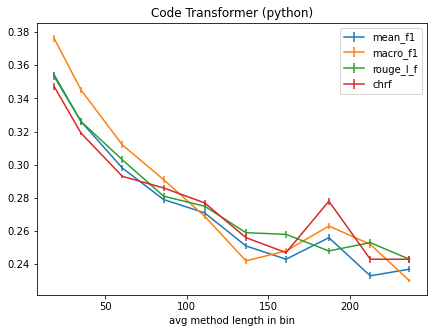

In [20]:
plt.figure(figsize=(7, 5))
plt.title('Code Transformer (python)')
plt.xlabel('avg method length in bin')
for xs, ys, errors, metric_name in res_balanced['code_transformer-balanced_normilized_weights-50000']['python']:
    plt.errorbar(xs, ys, yerr=errors, label=metric_name)
plt.legend()
plt.show()